## Detecção de Fraudes em Transações Financeiras

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

### Importação e Análise Exploratória dos Dados

In [5]:
# Importando dados
df = pd.read_csv('dataset.csv')

In [3]:
# Visualização geral
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
# Tamanho do dataset
df.shape

(6362620, 11)

In [8]:
# Verificando tipo dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
# Verificando colunas
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [10]:
# Verificando valores nulos
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
# Verificando valores duplicados
df.duplicated().sum()

0

In [12]:
# Distribuição de valores da variável isFraud
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [13]:
# Distribuição de valores da variável isFlaggedFraud
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [19]:
# Porcentagem de fraudes
f'{round((df['isFraud'].value_counts()[1] / df.shape[0]) * 100,2)}%'

'0.13%'

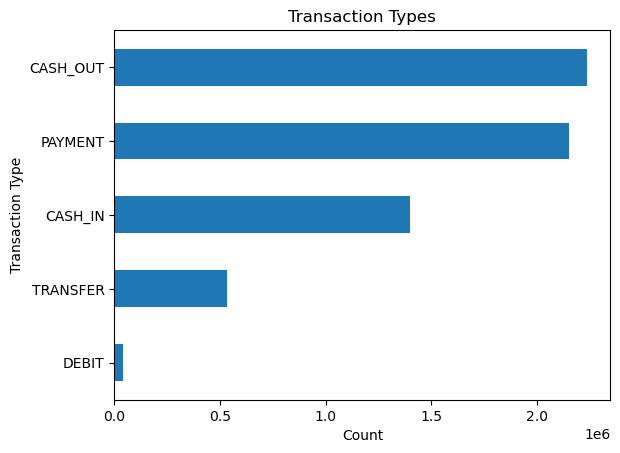

In [14]:
# Gráfico - tipos de transações
df['type'].value_counts().sort_values().plot(kind='barh', title='Transaction Types')
plt.xlabel('Count')
plt.ylabel('Transaction Type')
plt.show()

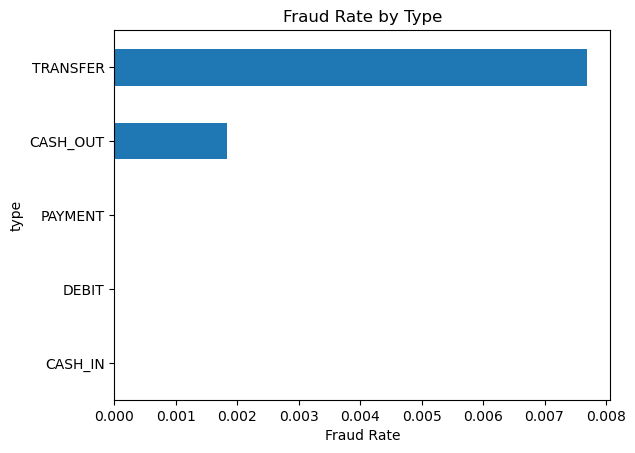

In [15]:
# Gráfico - total de fraudes por tipo de transações
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values()
fraud_by_type.plot(kind='barh', title='Fraud Rate by Type')
plt.xlabel('Fraud Rate')
plt.show()

In [16]:
# Total de fraudes por tipo de transações
fraud_by_type

type
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
CASH_OUT    0.001840
TRANSFER    0.007688
Name: isFraud, dtype: float64

In [17]:
# Distribuição dos valores das transações
df['amount'].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

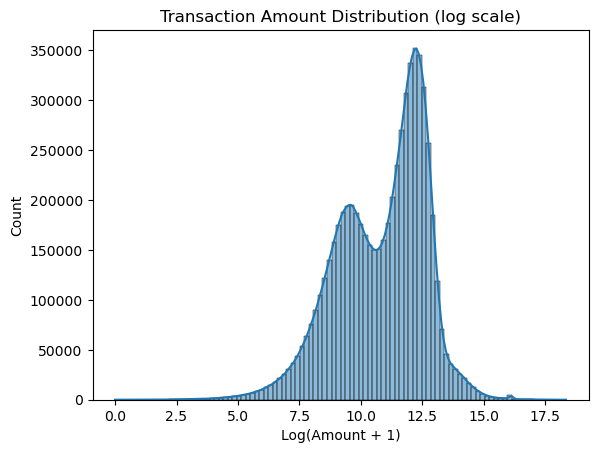

In [25]:
# Dada a assimetria da distribuição dos valores, foi aplicada escala logarítmica para visualização gráfica
sns.histplot(np.log1p(df['amount']), bins=100, kde=True)
plt.title('Transaction Amount Distribution (log scale)')
plt.xlabel('Log(Amount + 1)')
plt.show()

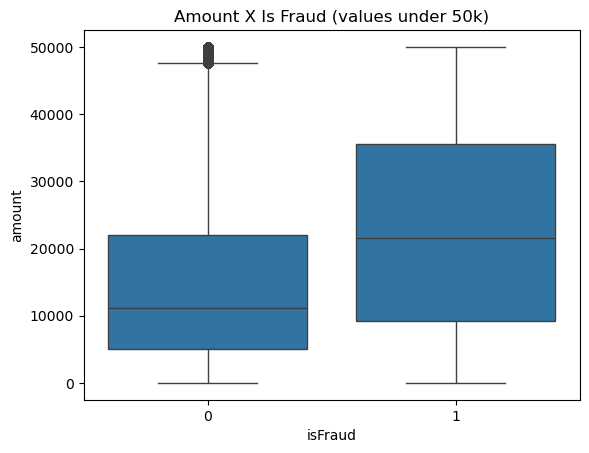

In [24]:
# Avaliando a distribuição de valores em transações legítimas e fraudulentas com valores < 50 mil
# -  De acordo com o boxplot: transações fraudulentas envolvem valores mais altos e têm maior dispersão
sns.boxplot(data=df[df['amount'] < 50000], x='isFraud', y='amount')
plt.title('Amount X Is Fraud (values under 50k)')
plt.show()

### Analisando anomalias em envio e recebimento de saldo

In [27]:
# Diferença de saldo da conta remetente após envio de valor
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']

# Diferença de saldo da conta destinatária após recebimento de valor
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [28]:
# Verificando anomalia -> aumento de saldo após o envio de valor
(df['balanceDiffOrig'] < 0).sum()

1399253

In [29]:
# Verificando anomalia -> diminuição de saldo após recebimento de valor
(df['balanceDiffDest'] < 0).sum()

1238864

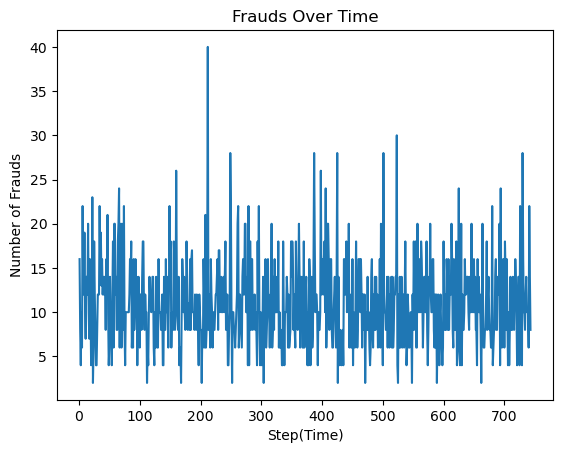

In [30]:
# Verificando fraudes ao longo do tempo
# No geral, não é possível identificar relação tempo x fraudes, podemos descartar a coluna step
frauds_per_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
plt.plot(frauds_per_step.index, frauds_per_step.values, label='Frauds per Step')
plt.xlabel('Step(Time)')
plt.ylabel('Number of Frauds')
plt.title('Frauds Over Time')
plt.show()

In [31]:
# Deletando coluna stp
df.drop(columns='step', inplace=True)

### Analisando comportamento de usuários

In [32]:
# Top senders
top_senders = df['nameOrig'].value_counts().head(10)
top_senders

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [33]:
# Top receivers
top_receivers = df['nameDest'].value_counts().head(10)
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [34]:
# Relação usuários x fraudes
fraud_users = df[df['isFraud'] == 1]['nameOrig'].value_counts().head(10)
fraud_users

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

In [35]:
# Distribuição de fraudes de acordo com o tipo de transação
fraud_types = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]
fraud_types['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

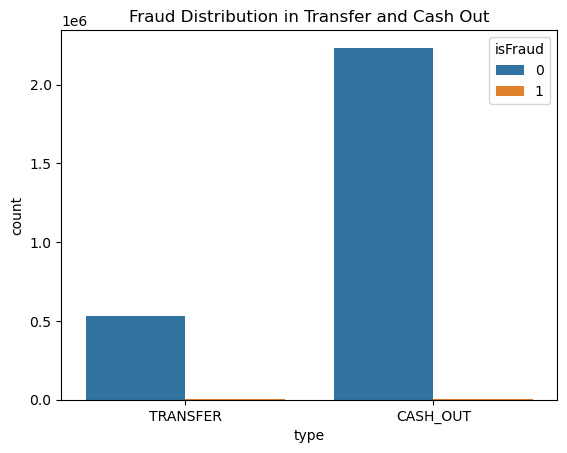

In [36]:
# Visualizando a distribuição de fraudes de acordo com o tipo de transação
sns.countplot(data=fraud_types, x='type', hue='isFraud')
plt.title('Fraud Distribution in Transfer and Cash Out')
plt.show()

In [37]:
#
zero_after_transfer = df[
    (df['oldbalanceOrg'] > 0) &
    (df['newbalanceOrig'] == 0) &
    (df['type'].isin(['TRANSFER', 'CASHOUT']))
]

len(zero_after_transfer)

228662

In [38]:
zero_after_transfer.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
2,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0,181.00,0.00
19,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,705.00,-22425.00
24,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,10835.00,2712905.89
78,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,10363.39,-33857.48
123,TRANSFER,330757.04,C1494346128,103657.00,0.0,C564160838,79676.00,1254956.07,0,0,103657.00,1175280.07


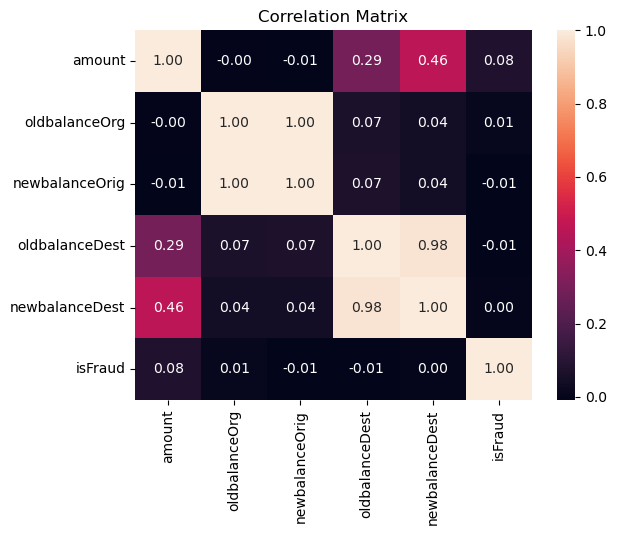

In [39]:
# Matriz de correlação
corr = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()

sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Preparando dados para nosso modelo preditivo

In [40]:
# Deletando colunas que não serão úteis para nosso modelo
df_model = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)
df_model.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,-21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [41]:
# Separando em variáveis categóricas e numéricas
categorical = ['type']
numeric = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [42]:
# Variável target
y = df_model['isFraud']

# Variáveis preditoras
X = df_model.drop('isFraud', axis=1)

In [43]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [45]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ],
    remainder = 'drop'
)

In [46]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

In [47]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['type'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [49]:
y_pred = pipeline.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.94      0.97   1908786



In [51]:
confusion_matrix(y_test, y_pred)

array([[1800322,  106000],
       [    155,    2309]], dtype=int64)

In [53]:
pipeline.score(X_test, y_test) * 100

94.43861176685077

In [54]:
import joblib

joblib.dump(pipeline, 'fraud_detection_pipeline.pkl')

['fraud_detection_pipeline.pkl']